# Load data

In [24]:
import pandas as pd
path2 = "https://raw.githubusercontent.com/allen1yuan/astro_data/main/datathon_2024_dataset.csv"
path = "https://raw.githubusercontent.com/allen1yuan/astro_data/main/datathon_clean.csv"
orginal = "/content/datathon_2024_dataset.csv"
df = pd.read_csv(orginal)
df.drop(columns=df.columns[0], axis=1, inplace=True) # Remove redundant index column

# Identify if away_team traveled or not


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(20, 20))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()
df.shape

(56775, 28)

In [ ]:
# Combining the data back for ease of analysis
combined_data = df.copy()
combined_data.sort_values(by=['away_team', 'game_date'], inplace=True)

# Initialize a column to mark travel
combined_data['away_team_traveled'] = 0

# Modifying the detect_travel function to handle the first game
def detect_travel_modified(group):
    # Make sure sort by game_date
    group = group.sort_values(by='game_date')

    # Shift the previous city to the next row for comparison
    group['prev_city'] = group['city'].shift(1)

    # If the current city is different from the previous city, mark as traveled. If it's the first game, mark as not traveled.
    group['away_team_traveled'] = ((group['city'] != group['prev_city']) & group['prev_city'].notnull()).astype(int)

    # Drop the temporary column 'prev_city' for the next comparison
    group.drop('prev_city', axis=1, inplace=True)
    return group

# Detect if the away_team traveled for today's game or not
combined_data = combined_data.groupby('away_team').apply(detect_travel_modified)

combined_data.reset_index(drop=True, inplace=True)

combined_data.head()

# Measure off-days for away_team

In [27]:
# Calculate rest days
combined_data['prev_game_date'] = combined_data.groupby('away_team')['game_date'].shift(1)
combined_data['rest_days'] = (combined_data['game_date'] - combined_data['prev_game_date'])

# Replace NaN in rest_days for the first game of each team with an appropriate value
combined_data['rest_days'].fillna(0, inplace=True)

# Measure travel distance for away_team

### get geo-info for each city

In [11]:
combined_data['city'].unique()

array(['Chicago', 'Toronto', 'St. Petersburg', 'Baltimore', 'Seattle',
       'Minneapolis', 'Kansas City', 'Cleveland', 'Phoenix',
       'Los Angeles', 'San Diego', 'Oakland', 'Arlington', 'New York',
       'Boston', 'Detroit', 'San Francisco', 'Denver', 'St. Louis',
       'Milwaukee', 'San Juan', 'Miami', 'Pittsburgh', 'Houston',
       'Atlanta', 'Cincinnati', 'Philadelphia', 'Washington', 'Dunedin',
       'Williamsport', 'Montreal', 'Anaheim', 'Buffalo', 'Tokyo',
       'Dyersville', 'Omaha', 'Monterrey', 'Sydney', 'Fort Bragg',
       'London', 'Lake Buena Vista'], dtype=object)

In [15]:
cities = ['Chicago', 'Toronto', 'St. Petersburg', 'Baltimore', 'Seattle',
       'Minneapolis', 'Kansas City', 'Cleveland', 'Phoenix',
       'Los Angeles', 'San Diego', 'Oakland', 'Arlington', 'New York',
       'Boston', 'Detroit', 'San Francisco', 'Denver', 'St. Louis',
       'Milwaukee', 'San Juan', 'Miami', 'Pittsburgh', 'Houston',
       'Atlanta', 'Cincinnati', 'Philadelphia', 'Washington', 'Dunedin',
       'Williamsport', 'Montreal', 'Anaheim', 'Buffalo', 'Tokyo',
       'Dyersville', 'Omaha', 'Monterrey', 'Sydney', 'Fort Bragg',
       'London', 'Lake Buena Vista']

coord = {}
import requests
# Get latitude and longitude
key = 'E7KAcQXxCt3zWTuPNGRLwA==WJUto5jdJHFIucp7'

for city in cities:
    api_url = f'https://api.api-ninjas.com/v1/geocoding?city={city}'
    response = requests.get(api_url, headers={'X-Api-Key': key})
    if response.status_code == requests.codes.ok:
        data = response.json()
        # Check if data is not empty and return the first result
        if data:
              coord[city] = [data[0]['latitude'], data[0]['longitude']]
        else:
            print('error')
    else:
        print("Error:", response.status_code, response.text)

In [28]:
# Map the city locations to the DataFrame
combined_data['location'] = combined_data['city'].map(coord)

# Split the location into lat and lon columns
combined_data[['lat', 'lon']] = pd.DataFrame(combined_data['location'].tolist(), index=combined_data.index)

combined_data.drop(columns=['location'], inplace=True)

In [29]:
# Calculate distance between two points use Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Calculate the previous venue's lat and lon for each game
combined_data['prev_lat'] = combined_data.groupby('away_team')['lat'].shift(1)
combined_data['prev_lon'] = combined_data.groupby('away_team')['lon'].shift(1)

# Calculate the travel distance using the Haversine formula
combined_data['travel_distance'] = combined_data.apply(
    lambda row: haversine(row['prev_lon'], row['prev_lat'], row['lon'], row['lat'])
    if pd.notnull(row['prev_lon']) and pd.notnull(row['prev_lat']) else 0,
    axis=1
)

combined_data.drop(columns=['prev_lat', 'prev_lon'], inplace=True)

In [31]:
combined_data.columns

Index(['game_date', 'home_team', 'away_team', 'is_day_game', 'home_score',
       'away_score', 'venue', 'venue_name', 'city', 'state', 'home_pa',
       'home_1b', 'home_2b', 'home_3b', 'home_hr', 'home_fo', 'home_so',
       'home_bb', 'home_hbp', 'away_pa', 'away_1b', 'away_2b', 'away_3b',
       'away_hr', 'away_fo', 'away_so', 'away_bb', 'away_hbp',
       'away_team_traveled', 'prev_game_date', 'rest_days', 'lat', 'lon',
       'travel_distance'],
      dtype='object')

### Calculate performance

In [100]:
# Calculating total hits for the away team and home team
combined_data['away_hits'] = combined_data['away_1b'] + combined_data['away_2b'] + combined_data['away_3b'] + combined_data['away_hr']
combined_data['home_hits'] = combined_data['home_1b'] + combined_data['home_2b'] + combined_data['home_3b'] + combined_data['home_hr']
# Setting weights for each component (for simplicity, we use equal weights here except for final score)
w_final_scored = 5
w_hits = 1
w_strikeouts = -1  # Negative because fewer strikeouts are better
w_walks = 1
w_hbp = 1

# Calculating the performance score
combined_data['away_performance_score'] = (
    (combined_data['away_score'] * w_final_scored) +
    (combined_data['away_hits'] * w_hits) +
    (combined_data['away_so'] * w_strikeouts) +
    (combined_data['away_bb'] * w_walks) +
    (combined_data['away_hbp'] * w_hbp)
)
combined_data['home_performance_score'] = (
    (combined_data['home_score'] * w_final_scored) +
    (combined_data['home_hits'] * w_hits) +
    (combined_data['home_so'] * w_strikeouts) +
    (combined_data['home_bb'] * w_walks) +
    (combined_data['home_hbp'] * w_hbp)
)

In [101]:
combined_data['away_win'] = (combined_data['away_performance_score'] > combined_data['home_performance_score']).astype(int)

In [38]:
combined_data.to_csv('final_data.csv', index=False)

### Labeling based on range

In [102]:
data = combined_data.copy()

In [103]:
from sklearn.preprocessing import LabelEncoder

for column in df.columns:
    if data[column].dtype == 'object':  # If the column is a string
        le = LabelEncoder()
        data[column] = le.fit_transform(df[column].fillna(''))  # Fill NA values with an empty string and then transform

# Check effect
1. away_team travel distance vs. away_team performance

In [128]:
df_traveled = data[data['away_team_traveled'] == 1]
df_traveled['game_date'] = pd.to_datetime(df_traveled['game_date'], format='%Y%m%d')

<ipython-input-128-6253aaa33085>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



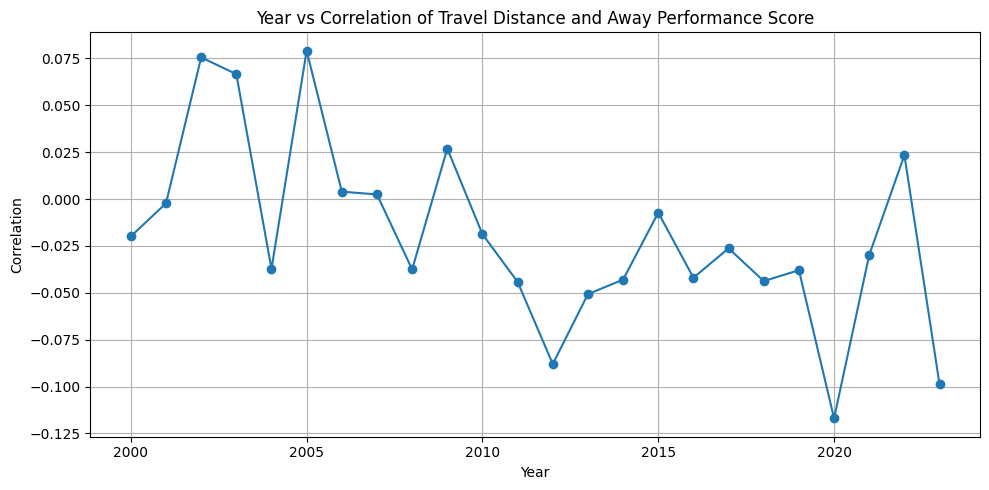

In [129]:
import matplotlib.pyplot as plt
years = list(range(2000, 2024))
correlations = []

# Calculate correlation for each year and store it
for year in years:
    segment_data = df_traveled[df_traveled['game_date'].dt.year == year]
    X = segment_data['travel_distance']
    y = segment_data['away_performance_score']
    correlation = X.corr(y)
    correlations.append(correlation)

plt.figure(figsize=(10, 5))
plt.plot(years, correlations, marker='o')
plt.title('Year vs Correlation of Travel Distance and Away Performance Score')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()


2. Check if team recovering from the travel in the following day games:
the slope of performance_score is averagely positive after travel to a city.

In [133]:
data['game_date'] = pd.to_datetime(data['game_date'], format='%Y%m%d')

In [137]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np


# Create a new column 'segment_id' that increments every time 'away_team_traveled' is 1
data['segment_id'] = (data['away_team_traveled'] == 1).cumsum()

slopes = []
grouped = data.groupby('segment_id')

# Iterate over each segment
for segment_id, segment_data in grouped:
    # Ensure the segment has enough data points for regression
    if len(segment_data) >= 2:
        X = segment_data['game_date'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
        y = segment_data['away_performance_score'].values.reshape(-1, 1)

        # Perform Linear Regression
        regr = LinearRegression().fit(X, y)

        # Get the slope (coefficient) of the regression line
        slope = regr.coef_[0][0]
        slopes.append(slope)
        # print(f"Segment {segment_id}, Slope: {slope}")
    # else:
        # print(f"Segment {segment_id} skipped, not enough data points")

# Analyze the overall trend based on the slopes of each segment
average_slope = np.mean(slopes)
print(f"Average slope across all segments: {average_slope}")

# Check if there is an overall increasing trend
if average_slope > 0:
    print("There is an overall increasing trend in away_performance_score.")
elif average_slope < 0:
    print("There is an overall decreasing trend in away_performance_score.")
else:
    print("The away_performance_score is relatively stable across the segments.")


Average slope across all segments: -0.09958710799384389
There is an overall decreasing trend in away_performance_score.
